In [1]:
import os
import random
from os import listdir, getcwd
import cv2
import shutil
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Mount the google drive 

from google.colab import drive
drive.mount('/content/gdrive')

## Fetch the Data

In [3]:
path = '/content/gdrive/My Drive/Face_mask/files/'
Mask_path = '/content/gdrive/My Drive/Face_mask/files/with_mask/'
No_mask_path = '/content/gdrive/My Drive/Face_mask/files/without_mask/'
Test_Path = '/content/gdrive/My Drive/Face_mask/testdata'

In [4]:
print("The number of images with facemask labelled 'with mask':",len(os.listdir(Mask_path)))
print("The number of images with facemask labelled 'without mask':",len(os.listdir(No_mask_path)))

The number of images with facemask labelled 'with mask': 596
The number of images with facemask labelled 'without mask': 592


It can be seen that the dataset is balanced

# Visualize the data

In [5]:
def show_img(path):
    images = list()
    for img in random.sample(os.listdir(path),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(path,images[i])))
            i+=1

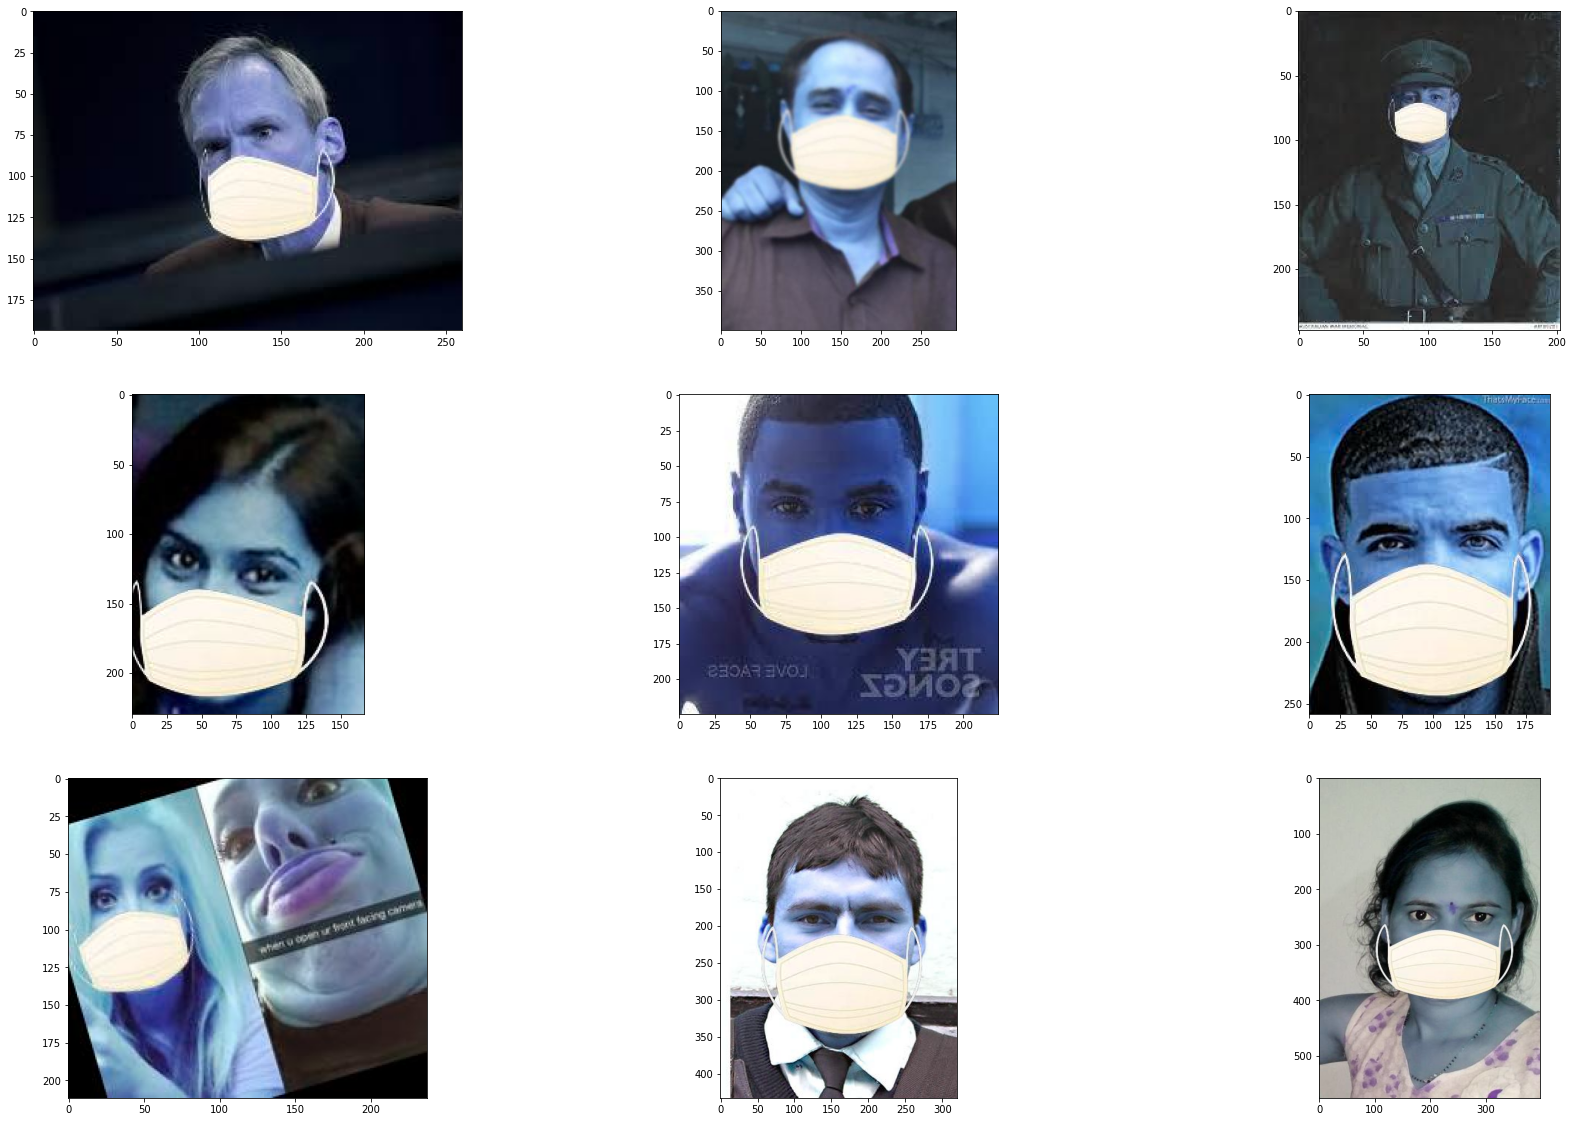

In [6]:
show_img(Mask_path)

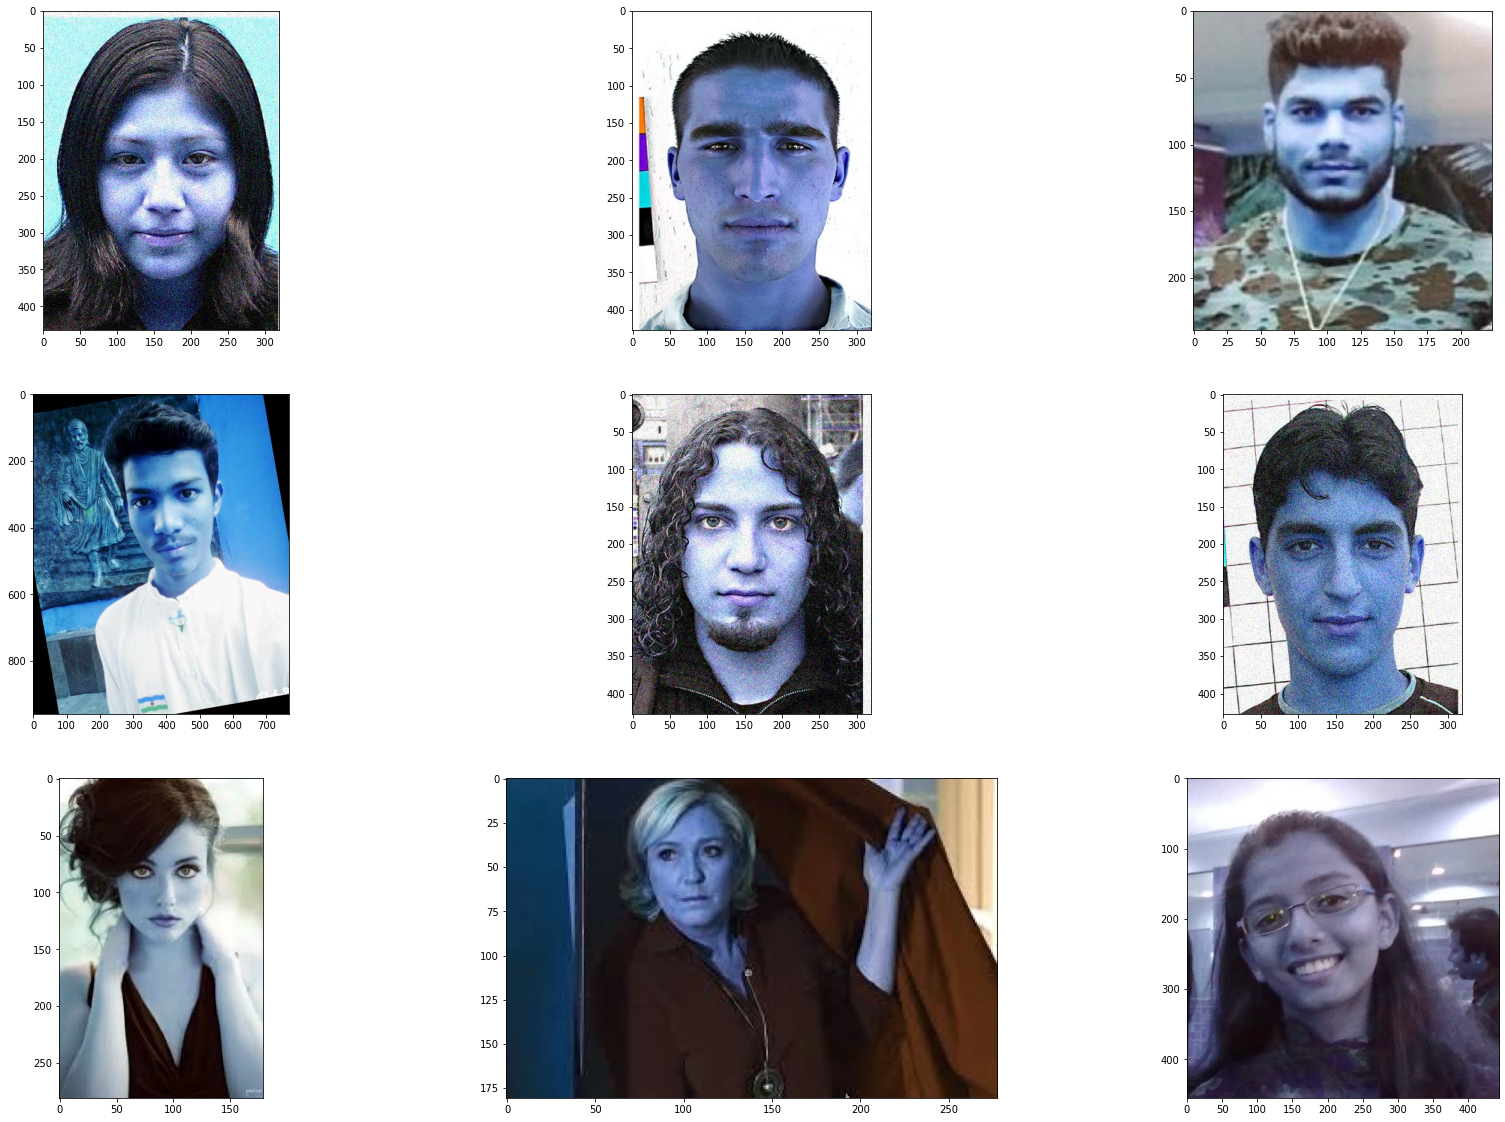

In [7]:
show_img(No_mask_path)

# Split the data for testing: here I'm taking 2% of total data

In [8]:
os.mkdir(Test_Path)
os.mkdir(os.path.join(Test_Path,'with_mask'))
os.mkdir(os.path.join(Test_Path,'without_mask'))

In [9]:
def Test_data(pth):
    dataSplit = int(np.ceil(len(os.listdir(pth))*0.02))
    for img in os.listdir(pth)[-dataSplit:]:
        shutil.move(os.path.join(pth,img), os.path.join('testdata'.join(pth.split('files')),img))
Test_data(Mask_path)
Test_data(No_mask_path)

In [10]:
len(os.listdir(Mask_path)), len(os.listdir(No_mask_path))

(584, 580)

In [11]:
len(os.listdir(os.path.join(Test_Path,'with_mask'))), len(os.listdir(os.path.join(Test_Path,'without_mask')))

(12, 12)

## **Preparing input data**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale= 1./255)

In [13]:
batch_size = 32

train_dataset = train_datagen.flow_from_directory(
                path,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

validation_dataset = train_datagen.flow_from_directory(
                path,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

test_dataset = test_datagen.flow_from_directory(
                Test_Path,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

Found 1164 images belonging to 2 classes.
Found 1164 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


# Model built using transfer learning

In [14]:
from tensorflow.keras.applications import MobileNetV2

# MobileNet is designed to work with images of dim 224,224
img_rows, img_cols = 224,224

MobileNet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
for layer in MobileNet.layers:
    layer.trainable = False

In [16]:
model = Sequential()
model.add(MobileNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [17]:
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint('Facemask_mobilNet.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)
callbacks = [earlystop,checkpoint,learning_rate_reduction]

In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [19]:
epochs = 25
batch_size = 32
#nb_train_samples = 1214

history = model.fit(
            train_dataset,
            steps_per_epoch=35,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_dataset,
            )

Epoch 1/25
35/35 [==============================] - ETA: 0s - loss: 0.0892 - accuracy: 0.9645 
Epoch 00001: val_loss improved from inf to 0.01198, saving model to Facemask_mobilNet.h5
35/35 [==============================] - 495s 14s/step - loss: 0.0892 - accuracy: 0.9645 - val_loss: 0.0120 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 2/25
35/35 [==============================] - ETA: 0s - loss: 0.0261 - accuracy: 0.9891
Epoch 00002: val_loss did not improve from 0.01198
35/35 [==============================] - 14s 388ms/step - loss: 0.0261 - accuracy: 0.9891 - val_loss: 0.0170 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 3/25
35/35 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9964
Epoch 00003: val_loss improved from 0.01198 to 0.00609, saving model to Facemask_mobilNet.h5
35/35 [==============================] - 14s 399ms/step - loss: 0.0177 - accuracy: 0.9964 - val_loss: 0.0061 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 4/25
35/35 [==============================] 

In [20]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 1ms/step - loss: 2.6403e-05 - accuracy: 1.0000


[2.640290949784685e-05, 1.0]